# Детекция объектов

<p style="align: center;"><img src="https://static.tildacdn.com/tild6636-3531-4239-b465-376364646465/Deep_Learning_School.png", width=500></p>

<h3 style="text-align: center;"><b>Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ</b></h3>

## Загрузка предобученной модели

Загрузим предобученную nvidia ssd

In [48]:
import torch

In [49]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
ssd_nvidia = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_ssd').to(device)
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_ssd_processing_utils')

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


Посмотрим на неокторые изображения из датасета coco

In [50]:
ssd_nvidia.eval()
uris = [
    'http://images.cocodataset.org/val2017/000000397133.jpg',
    'http://images.cocodataset.org/val2017/000000037777.jpg',
    'http://images.cocodataset.org/val2017/000000252219.jpg'
]
inputs = [utils.prepare_input(uri) for uri in uris]
tensor = utils.prepare_tensor(inputs)
with torch.no_grad():
    detections_batch = ssd_nvidia(tensor)

detections_batch = [d.to('cpu') for d in detections_batch]
results_per_input = utils.decode_results(detections_batch)
best_results_per_input = [utils.pick_best(results, 0.40) for results in results_per_input]
classes_to_labels = utils.get_coco_object_dictionary()

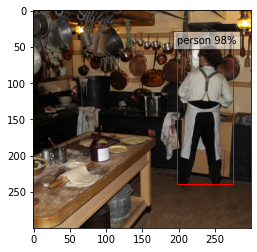

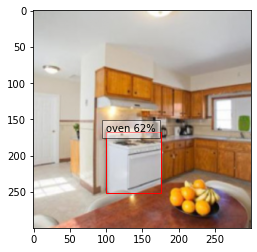

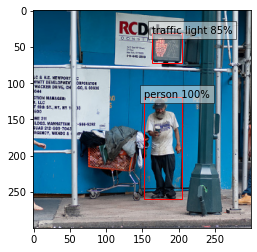

In [51]:
from matplotlib import pyplot as plt
import matplotlib.patches as patches

for image_idx in range(len(best_results_per_input)):
    fig, ax = plt.subplots(1)
    # Show original, denormalized image...
    image = inputs[image_idx] / 2 + 0.5
    ax.imshow(image)
    # ...with detections
    bboxes, classes, confidences = best_results_per_input[image_idx]
    for idx in range(len(bboxes)):
        left, bot, right, top = bboxes[idx]
        x, y, w, h = [val * 300 for val in [left, bot, right - left, top - bot]]
        rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(x, y, "{} {:.0f}%".format(classes_to_labels[classes[idx] - 1], confidences[idx]*100), bbox=dict(facecolor='white', alpha=0.5))
plt.show()

## Импорты

In [52]:
import numpy as np
import pandas as pd
from tqdm import notebook
import time

import torch
from torchvision import models
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn.functional as F
import torchvision

from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

import os
import json
import re
import random
from math import sqrt

###  Посмотрим на некоторые изображения

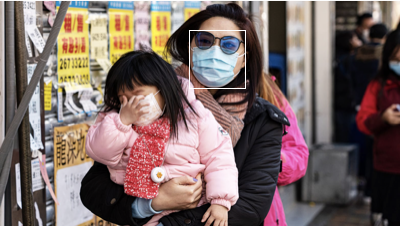

In [53]:
with open('/kaggle/input/face-mask-detection/annotations/maksssksksss100.xml') as f:
    reader = f.read()

img = Image.open('/kaggle/input/face-mask-detection/images/maksssksksss100.png')

xmin = int(re.findall('(?<=<xmin>)[0-9]+?(?=</xmin>)', reader)[0])
xmax = int(re.findall('(?<=<xmax>)[0-9]+?(?=</xmax>)', reader)[0])
ymin = int(re.findall('(?<=<ymin>)[0-9]+?(?=</ymin>)', reader)[0])
ymax = int(re.findall('(?<=<ymax>)[0-9]+?(?=</ymax>)', reader)[0])

origin_img = img.copy()
draw = ImageDraw.Draw(origin_img)
draw.rectangle(xy=[(xmin,ymin), (xmax,ymax)])
origin_img

In [54]:
dims=(300, 300)
old_dims = torch.FloatTensor([img.width, img.height, img.width, img.height]).unsqueeze(0)
box = torch.FloatTensor([xmin, ymin, xmax, ymax])
new_box = box / old_dims
new_dims = torch.FloatTensor([dims[1], dims[0], dims[1], dims[0]]).unsqueeze(0)
new_box = new_box * new_dims
new_box

tensor([[141.7500,  39.8230, 183.7500, 116.8142]])

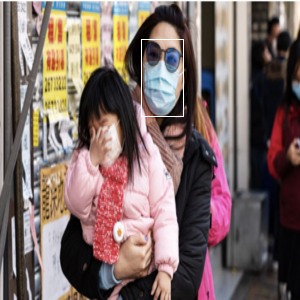

In [55]:
img = transforms.Resize(dims)(img)
draw = ImageDraw.Draw(img)
draw.rectangle(xy=[tuple(new_box.tolist()[0])[:2], tuple(new_box.tolist()[0])[2:]])
img

## Dataset

Датасетом являются изображения людей в масках и без, он есть по [ссылке](https://www.kaggle.com/datasets/andrewmvd/face-mask-detection)

In [56]:
label_map = {'face': 1}

rev_label_map = {
    1: 'face',
    0: 'background'
}

In [57]:
all_img_name = os.listdir('/kaggle/input/face-mask-detection/images/')
len(all_img_name), all_img_name[0]

(853, 'maksssksksss810.png')

In [58]:
class SSDDateset(Dataset):
    def __init__(self, file_folder, is_test=False, transform=None):
        self.img_folder_path = '/kaggle/input/face-mask-detection/images/'
        self.annotation_folder_path = '/kaggle/input/face-mask-detection/annotations/'
        self.file_folder = file_folder
        self.transform = transform
        self.is_test = is_test
        
    def __getitem__(self, idx):
        file = self.file_folder[idx]
        img_path = self.img_folder_path + file
        img = Image.open(img_path)
        img = img.convert('RGB')
        
        if not self.is_test:
            annotation_path = self.annotation_folder_path + file.split('.')[0] + '.xml'
            with open(annotation_path) as f:
                annotation = f.read()

            xy = self.get_xy(annotation)
            box = torch.FloatTensor(list(xy))

            new_box = self.box_resize(box, img)
            if self.transform is not None:
                img = self.transform(img)

            return img, new_box, torch.FloatTensor([1])
        else:
            return img
    
    def __len__(self):
        return len(self.file_folder)
        
    def get_xy(self, annotation):
        xmin = int(re.findall('(?<=<xmin>)[0-9]+?(?=</xmin>)', annotation)[0])
        xmax = int(re.findall('(?<=<xmax>)[0-9]+?(?=</xmax>)', annotation)[0])
        ymin = int(re.findall('(?<=<ymin>)[0-9]+?(?=</ymin>)', annotation)[0])
        ymax = int(re.findall('(?<=<ymax>)[0-9]+?(?=</ymax>)', annotation)[0])
        
        return xmin, ymin, xmax, ymax
    
    def show_box(self):
        file = random.choice(self.file_folder)
        annotation_path = self.annotation_folder_path + file.split('.')[0]
        
        img_box = Image.open(self.img_folder_path + file)
        with open(annotation_path) as f:
            annotation = f.read()
            
        draw = ImageDraw.Draw(img_box)
        xy = self.get_xy(annotation)
        print('bbox:', xy)
        draw.rectangle(xy=[xy[:2], xy[2:]])
        
        return img_box
        
    def box_resize(self, box, img, dims=(300, 300)):
        old_dims = torch.FloatTensor([img.width, img.height, img.width, img.height]).unsqueeze(0)
        new_box = box / old_dims
        new_dims = torch.FloatTensor([dims[1], dims[0], dims[1], dims[0]]).unsqueeze(0)
        
        return new_box
    
    def collate_fn(self, batch):
        images = list()
        boxes = list()
        labels = list()

        for b in batch:
            images.append(b[0])
            boxes.append(b[1])
            labels.append(b[2])

        images = torch.stack(images, dim=0)

        return images, boxes, labels

In [59]:
tsfm = transforms.Compose([
    transforms.Resize([300, 300]),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

## Вспомогательные функции

In [60]:
def xy_to_cxcy(xy):
    return torch.cat([(xy[:, 2:] + xy[:, :2]) / 2, xy[:, 2:] - xy[:, :2]], 1)


def cxcy_to_xy(cxcy):
    return torch.cat([cxcy[:, :2] - (cxcy[:, 2:] / 2), cxcy[:, :2] + (cxcy[:, 2:] / 2)], 1)


def cxcy_to_gcxgcy(cxcy, priors_cxcy):
    return torch.cat([(cxcy[:, :2] - priors_cxcy[:, :2]) / (priors_cxcy[:, 2:] / 10), torch.log(cxcy[:, 2:] / priors_cxcy[:, 2:]) * 5], 1)


def gcxgcy_to_cxcy(gcxgcy, priors_cxcy):

    return torch.cat([gcxgcy[:, :2] * priors_cxcy[:, 2:] / 10 + priors_cxcy[:, :2], torch.exp(gcxgcy[:, 2:] / 5) * priors_cxcy[:, 2:]], 1) 

def find_jaccard_overlap(set_1, set_2):
    intersection = find_intersection(set_1, set_2)

    areas_set_1 = (set_1[:, 2] - set_1[:, 0]) * (set_1[:, 3] - set_1[:, 1])
    areas_set_2 = (set_2[:, 2] - set_2[:, 0]) * (set_2[:, 3] - set_2[:, 1])

    union = areas_set_1.unsqueeze(1) + areas_set_2.unsqueeze(0) - intersection

    return intersection / union  # (n1, n2)

def find_intersection(set_1, set_2):
    lower_bounds = torch.max(set_1[:, :2].unsqueeze(1), set_2[:, :2].unsqueeze(0))
    upper_bounds = torch.min(set_1[:, 2:].unsqueeze(1), set_2[:, 2:].unsqueeze(0))
    intersection_dims = torch.clamp(upper_bounds - lower_bounds, min=0)
    return intersection_dims[:, :, 0] * intersection_dims[:, :, 1]

def decimate(tensor, m):
    assert tensor.dim() == len(m)
    for d in range(tensor.dim()):
        if m[d] is not None:
            tensor = tensor.index_select(dim=d,
                                         index=torch.arange(start=0, end=tensor.size(d), step=m[d]).long())

    return tensor

def calculate_mAP(det_boxes, det_labels, det_scores, true_boxes, true_labels, true_difficulties):
    assert len(det_boxes) == len(det_labels) == len(det_scores) == len(true_boxes) == len(
        true_labels) == len(
        true_difficulties) 
    n_classes = len(label_map)

    true_images = list()
    for i in range(len(true_labels)):
        true_images.extend([i] * true_labels[i].size(0))
    true_images = torch.LongTensor(true_images).to(
        device)
    true_boxes = torch.cat(true_boxes, dim=0)
    true_labels = torch.cat(true_labels, dim=0)
    true_difficulties = torch.cat(true_difficulties, dim=0)

    assert true_images.size(0) == true_boxes.size(0) == true_labels.size(0)

    det_images = list()
    for i in range(len(det_labels)):
        det_images.extend([i] * det_labels[i].size(0))
    det_images = torch.LongTensor(det_images).to(device)
    det_boxes = torch.cat(det_boxes, dim=0)
    det_labels = torch.cat(det_labels, dim=0)
    det_scores = torch.cat(det_scores, dim=0)

    assert det_images.size(0) == det_boxes.size(0) == det_labels.size(0) == det_scores.size(0)

    average_precisions = torch.zeros((n_classes - 1), dtype=torch.float) 
    for c in range(1, n_classes):
        true_class_images = true_images[true_labels == c]
        true_class_boxes = true_boxes[true_labels == c] 
        true_class_difficulties = true_difficulties[true_labels == c]
        n_easy_class_objects = (1 - true_class_difficulties).sum().item() 


        true_class_boxes_detected = torch.zeros((true_class_difficulties.size(0)), dtype=torch.uint8).to(
            device)

        det_class_images = det_images[det_labels == c]
        det_class_boxes = det_boxes[det_labels == c]
        det_class_scores = det_scores[det_labels == c]
        n_class_detections = det_class_boxes.size(0)
        if n_class_detections == 0:
            continue
            
        det_class_scores, sort_ind = torch.sort(det_class_scores, dim=0, descending=True)
        det_class_images = det_class_images[sort_ind]
        det_class_boxes = det_class_boxes[sort_ind]

        true_positives = torch.zeros((n_class_detections), dtype=torch.float).to(device)
        false_positives = torch.zeros((n_class_detections), dtype=torch.float).to(device)
        for d in range(n_class_detections):
            this_detection_box = det_class_boxes[d].unsqueeze(0) 
            this_image = det_class_images[d] 

            object_boxes = true_class_boxes[true_class_images == this_image]
            object_difficulties = true_class_difficulties[true_class_images == this_image]
            if object_boxes.size(0) == 0:
                false_positives[d] = 1
                continue

            overlaps = find_jaccard_overlap(this_detection_box, object_boxes)
            max_overlap, ind = torch.max(overlaps.squeeze(0), dim=0)

            original_ind = torch.LongTensor(range(true_class_boxes.size(0)))[true_class_images == this_image][ind]

            if max_overlap.item() > 0.5:
                if object_difficulties[ind] == 0:
                    if true_class_boxes_detected[original_ind] == 0:
                        true_positives[d] = 1
                        true_class_boxes_detected[original_ind] = 1
                    else:
                        false_positives[d] = 1
            else:
                false_positives[d] = 1
        cumul_true_positives = torch.cumsum(true_positives, dim=0)
        cumul_false_positives = torch.cumsum(false_positives, dim=0)
        cumul_precision = cumul_true_positives / (
                cumul_true_positives + cumul_false_positives + 1e-10)
        cumul_recall = cumul_true_positives / n_easy_class_objects
        
        recall_thresholds = torch.arange(start=0, end=1.1, step=.1).tolist()
        precisions = torch.zeros((len(recall_thresholds)), dtype=torch.float).to(device)
        for i, t in enumerate(recall_thresholds):
            recalls_above_t = cumul_recall >= t
            if recalls_above_t.any():
                precisions[i] = cumul_precision[recalls_above_t].max()
            else:
                precisions[i] = 0.
        average_precisions[c - 1] = precisions.mean()

    mean_average_precision = average_precisions.mean().item()

    average_precisions = {rev_label_map[c + 1]: v for c, v in enumerate(average_precisions.tolist())}

    return average_precisions, mean_average_precision

## SSD

In [61]:
class VGGBase(nn.Module):
    def __init__(self):
        super(VGGBase, self).__init__()

        self.conv1_1 = nn.Conv2d(3, 64, 3, padding=1)
        self.conv1_2 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2_1 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, 3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True)  

        self.conv4_1 = nn.Conv2d(256, 512, 3, padding=1)
        self.conv4_2 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv4_3 = nn.Conv2d(512, 512, 3, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv5_1 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_2 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_3 = nn.Conv2d(512, 512, 3, padding=1)
        self.pool5 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)  

        self.conv6 = nn.Conv2d(512, 1024, 3, padding=6, dilation=6) 

        self.conv7 = nn.Conv2d(1024, 1024, 1)

        self.load_pretrained_layers()

    def forward(self, image):
        out = F.relu(self.conv1_1(image))  
        out = F.relu(self.conv1_2(out))  
        out = self.pool1(out)  

        out = F.relu(self.conv2_1(out))  
        out = F.relu(self.conv2_2(out))  
        out = self.pool2(out)  

        out = F.relu(self.conv3_1(out))
        out = F.relu(self.conv3_2(out))
        out = F.relu(self.conv3_3(out)) 
        out = self.pool3(out) 

        out = F.relu(self.conv4_1(out))
        out = F.relu(self.conv4_2(out)) 
        out = F.relu(self.conv4_3(out)) 
        conv4_3_feats = out 
        out = self.pool4(out) 

        out = F.relu(self.conv5_1(out))
        out = F.relu(self.conv5_2(out))
        out = F.relu(self.conv5_3(out))
        out = self.pool5(out) 

        out = F.relu(self.conv6(out))

        conv7_feats = F.relu(self.conv7(out))

        return conv4_3_feats, conv7_feats

    def load_pretrained_layers(self):
        state_dict = self.state_dict()
        param_names = list(state_dict.keys())

        pretrained_state_dict = torchvision.models.vgg16(pretrained=True).state_dict()
        pretrained_param_names = list(pretrained_state_dict.keys())

        for i, param in enumerate(param_names[:-4]):
            state_dict[param] = pretrained_state_dict[pretrained_param_names[i]]

        conv_fc6_weight = pretrained_state_dict['classifier.0.weight'].view(4096, 512, 7, 7)  
        conv_fc6_bias = pretrained_state_dict['classifier.0.bias']
        state_dict['conv6.weight'] = decimate(conv_fc6_weight, m=[4, None, 3, 3])
        state_dict['conv6.bias'] = decimate(conv_fc6_bias, m=[4])
        # fc7
        conv_fc7_weight = pretrained_state_dict['classifier.3.weight'].view(4096, 4096, 1, 1)
        conv_fc7_bias = pretrained_state_dict['classifier.3.bias']
        state_dict['conv7.weight'] = decimate(conv_fc7_weight, m=[4, 4, None, None])
        state_dict['conv7.bias'] = decimate(conv_fc7_bias, m=[4])

        self.load_state_dict(state_dict)

        print("\nLoaded base model.\n")

In [62]:
class AuxiliaryConvolutions(nn.Module):
    def __init__(self):
        super(AuxiliaryConvolutions, self).__init__()
        self.conv8_1 = nn.Conv2d(1024, 256, 1) 
        self.conv8_2 = nn.Conv2d(256, 512, 3, stride=2, padding=1) 

        self.conv9_1 = nn.Conv2d(512, 128, 1)
        self.conv9_2 = nn.Conv2d(128, 256, 3, stride=2, padding=1)

        self.conv10_1 = nn.Conv2d(256, 128, 1)
        self.conv10_2 = nn.Conv2d(128, 256, 3)

        self.conv11_1 = nn.Conv2d(256, 128, 1)
        self.conv11_2 = nn.Conv2d(128, 256, 3)
        
        self.init_conv2d()
        
    def init_conv2d(self):
        for c in self.children():
            if isinstance(c, nn.Conv2d):
                nn.init.xavier_uniform_(c.weight)
                nn.init.constant_(c.bias, 0.)
        
    def forward(self, conv7_feats):
        out = F.relu(self.conv8_1(conv7_feats))  
        out = F.relu(self.conv8_2(out))
        conv8_2_feats = out 

        out = F.relu(self.conv9_1(out))
        out = F.relu(self.conv9_2(out))
        conv9_2_feats = out

        out = F.relu(self.conv10_1(out))
        out = F.relu(self.conv10_2(out))
        conv10_2_feats = out

        out = F.relu(self.conv11_1(out))
        conv11_2_feats = F.relu(self.conv11_2(out))

        return conv8_2_feats, conv9_2_feats, conv10_2_feats, conv11_2_feats

In [63]:
class PredictionConvolutions(nn.Module):
    def __init__(self, n_classes):
        super(PredictionConvolutions, self).__init__()
        self.n_classes = n_classes
        
        n_boxes = {'conv4_3': 4,
                   'conv7': 6,
                   'conv8_2': 6,
                   'conv9_2': 6,
                   'conv10_2': 4,
                   'conv11_2': 4}
        
        self.loc_conv4_3 = nn.Conv2d(512, n_boxes['conv4_3'] * 4, 3, padding=1)
        self.loc_conv7 = nn.Conv2d(1024, n_boxes['conv7'] * 4, 3, padding=1)
        self.loc_conv8_2 = nn.Conv2d(512, n_boxes['conv8_2'] * 4, 3, padding=1)
        self.loc_conv9_2 = nn.Conv2d(256, n_boxes['conv9_2'] * 4, 3, padding=1)
        self.loc_conv10_2 = nn.Conv2d(256, n_boxes['conv10_2'] * 4, 3, padding=1)
        self.loc_conv11_2 = nn.Conv2d(256, n_boxes['conv11_2'] * 4, 3, padding=1)

        self.cl_conv4_3 = nn.Conv2d(512, n_boxes['conv4_3'] * n_classes, 3, padding=1)
        self.cl_conv7 = nn.Conv2d(1024, n_boxes['conv7'] * n_classes, 3, padding=1)
        self.cl_conv8_2 = nn.Conv2d(512, n_boxes['conv8_2'] * n_classes, 3, padding=1)
        self.cl_conv9_2 = nn.Conv2d(256, n_boxes['conv9_2'] * n_classes, 3, padding=1)
        self.cl_conv10_2 = nn.Conv2d(256, n_boxes['conv10_2'] * n_classes, 3, padding=1)
        self.cl_conv11_2 = nn.Conv2d(256, n_boxes['conv11_2'] * n_classes, 3, padding=1)
        
        self.init_conv2d()
        
    def init_conv2d(self):
        for c in self.children():
            if isinstance(c, nn.Conv2d):
                nn.init.xavier_uniform_(c.weight)
                nn.init.constant_(c.bias, 0.)

    def forward(self, conv4_3_feats, conv7_feats, conv8_2_feats, conv9_2_feats, conv10_2_feats, conv11_2_feats):
        batch_size = conv4_3_feats.size(0)

        l_conv4_3 = self.loc_conv4_3(conv4_3_feats) 
        l_conv4_3 = l_conv4_3.permute(0, 2, 3, 1).contiguous()
        l_conv4_3 = l_conv4_3.view(batch_size, -1, 4)

        l_conv7 = self.loc_conv7(conv7_feats)
        l_conv7 = l_conv7.permute(0, 2, 3, 1).contiguous()  
        l_conv7 = l_conv7.view(batch_size, -1, 4) 
        
        l_conv8_2 = self.loc_conv8_2(conv8_2_feats) 
        l_conv8_2 = l_conv8_2.permute(0, 2, 3, 1).contiguous() 
        l_conv8_2 = l_conv8_2.view(batch_size, -1, 4) 

        l_conv9_2 = self.loc_conv9_2(conv9_2_feats) 
        l_conv9_2 = l_conv9_2.permute(0, 2, 3, 1).contiguous() 
        l_conv9_2 = l_conv9_2.view(batch_size, -1, 4) 

        l_conv10_2 = self.loc_conv10_2(conv10_2_feats) 
        l_conv10_2 = l_conv10_2.permute(0, 2, 3, 1).contiguous() 
        l_conv10_2 = l_conv10_2.view(batch_size, -1, 4) 

        l_conv11_2 = self.loc_conv11_2(conv11_2_feats) 
        l_conv11_2 = l_conv11_2.permute(0, 2, 3, 1).contiguous() 
        l_conv11_2 = l_conv11_2.view(batch_size, -1, 4) 

        c_conv4_3 = self.cl_conv4_3(conv4_3_feats)  
        c_conv4_3 = c_conv4_3.permute(0, 2, 3, 1).contiguous()  
        c_conv4_3 = c_conv4_3.view(batch_size, -1, self.n_classes)  

        c_conv7 = self.cl_conv7(conv7_feats)
        c_conv7 = c_conv7.permute(0, 2, 3, 1).contiguous() 
        c_conv7 = c_conv7.view(batch_size, -1, self.n_classes)  

        c_conv8_2 = self.cl_conv8_2(conv8_2_feats)
        c_conv8_2 = c_conv8_2.permute(0, 2, 3, 1).contiguous()
        c_conv8_2 = c_conv8_2.view(batch_size, -1, self.n_classes)

        c_conv9_2 = self.cl_conv9_2(conv9_2_feats)
        c_conv9_2 = c_conv9_2.permute(0, 2, 3, 1).contiguous()
        c_conv9_2 = c_conv9_2.view(batch_size, -1, self.n_classes)

        c_conv10_2 = self.cl_conv10_2(conv10_2_feats) 
        c_conv10_2 = c_conv10_2.permute(0, 2, 3, 1).contiguous()
        c_conv10_2 = c_conv10_2.view(batch_size, -1, self.n_classes)

        c_conv11_2 = self.cl_conv11_2(conv11_2_feats)
        c_conv11_2 = c_conv11_2.permute(0, 2, 3, 1).contiguous() 
        c_conv11_2 = c_conv11_2.view(batch_size, -1, self.n_classes)

        locs = torch.cat([l_conv4_3, l_conv7, l_conv8_2, l_conv9_2, l_conv10_2, l_conv11_2], dim=1)  
        classes_scores = torch.cat([c_conv4_3, c_conv7, c_conv8_2, c_conv9_2, c_conv10_2, c_conv11_2], dim=1)  

        return locs, classes_scores

In [64]:
class SSD(nn.Module):
    def __init__(self, n_classes=2):
        super(SSD, self).__init__()
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.n_classes = n_classes
        
        self.base = VGGBase().cuda()
        self.aux_convs = AuxiliaryConvolutions().to(self.device)
        self.pred_convs = PredictionConvolutions(n_classes).to(self.device)
        
        self.rescale_factors = nn.Parameter(torch.FloatTensor(1, 512, 1, 1))
        nn.init.constant_(self.rescale_factors, 20)

        self.priors_cxcy = self.create_prior_boxes()
        
    def forward(self, image):
        conv4_3_feats, conv7_feats = self.base(image)

        norm = conv4_3_feats.pow(2).sum(dim=1, keepdim=True).sqrt() 
        conv4_3_feats = conv4_3_feats / norm 
        conv4_3_feats = conv4_3_feats * self.rescale_factors
        conv8_2_feats, conv9_2_feats, conv10_2_feats, conv11_2_feats = self.aux_convs(conv7_feats) 

        locs, classes_scores = self.pred_convs(conv4_3_feats, conv7_feats, conv8_2_feats, conv9_2_feats, conv10_2_feats, conv11_2_feats)

        return locs, classes_scores

    
    def create_prior_boxes(self):
        fmap_dims = {'conv4_3': 38,
                     'conv7': 19,
                     'conv8_2': 10,
                     'conv9_2': 5,
                     'conv10_2': 3,
                     'conv11_2': 1}

        obj_scales = {'conv4_3': 0.1,
                      'conv7': 0.2,
                      'conv8_2': 0.375,
                      'conv9_2': 0.55,
                      'conv10_2': 0.725,
                      'conv11_2': 0.9}

        aspect_ratios = {'conv4_3': [1., 2., 0.5],
                         'conv7': [1., 2., 3., 0.5, .333],
                         'conv8_2': [1., 2., 3., 0.5, .333],
                         'conv9_2': [1., 2., 3., 0.5, .333],
                         'conv10_2': [1., 2., 0.5],
                         'conv11_2': [1., 2., 0.5]}

        fmaps = list(fmap_dims.keys())

        prior_boxes = []

        for k, fmap in enumerate(fmaps):
            for i in range(fmap_dims[fmap]):
                for j in range(fmap_dims[fmap]):
                    cx = (j + 0.5) / fmap_dims[fmap]
                    cy = (i + 0.5) / fmap_dims[fmap]

                    for ratio in aspect_ratios[fmap]:
                        prior_boxes.append([cx, cy, obj_scales[fmap] * sqrt(ratio), obj_scales[fmap] / sqrt(ratio)])
                        
                        if ratio == 1.:
                            try:
                                additional_scale = sqrt(obj_scales[fmap] * obj_scales[fmaps[k + 1]])
                            except IndexError:
                                additional_scale = 1.
                            prior_boxes.append([cx, cy, additional_scale, additional_scale])

        prior_boxes = torch.FloatTensor(prior_boxes).to(self.device)
        prior_boxes.clamp_(0, 1)

        return prior_boxes
    
    def detect_objects(self, predicted_locs, predicted_scores, min_score, max_overlap, top_k):
        batch_size = predicted_locs.size(0)
        n_priors = self.priors_cxcy.size(0)
        predicted_scores = F.softmax(predicted_scores, dim=2)

        all_images_boxes = list()
        all_images_labels = list()
        all_images_scores = list()

        assert n_priors == predicted_locs.size(1) == predicted_scores.size(1)

        for i in range(batch_size):
            decoded_locs = cxcy_to_xy(gcxgcy_to_cxcy(predicted_locs[i], self.priors_cxcy)) 
            image_boxes = list()
            image_labels = list()
            image_scores = list()

            max_scores, best_label = predicted_scores[i].max(dim=1)

            for c in range(1, self.n_classes):
                class_scores = predicted_scores[i][:, c]
                score_above_min_score = class_scores > min_score
                n_above_min_score = score_above_min_score.sum().item()
                if n_above_min_score == 0:
                    continue
                class_scores = class_scores[score_above_min_score]
                class_decoded_locs = decoded_locs[score_above_min_score]

                class_scores, sort_ind = class_scores.sort(dim=0, descending=True)
                class_decoded_locs = class_decoded_locs[sort_ind]

                overlap = find_jaccard_overlap(class_decoded_locs, class_decoded_locs)

                suppress = torch.zeros((n_above_min_score), dtype=torch.uint8).to(self.device)

                for box in range(class_decoded_locs.size(0)):
                    if suppress[box] == 1:
                        continue

                    suppress = torch.max(suppress, overlap[box] > max_overlap)


                    suppress[box] = 0

                image_boxes.append(class_decoded_locs[1 - suppress])
                image_labels.append(torch.LongTensor((1 - suppress).sum().item() * [c]).to(self.device))
                image_scores.append(class_scores[1 - suppress])

            if len(image_boxes) == 0:
                image_boxes.append(torch.FloatTensor([[0., 0., 1., 1.]]).to(self.device))
                image_labels.append(torch.LongTensor([0]).to(self.device))
                image_scores.append(torch.FloatTensor([0.]).to(self.device))

            image_boxes = torch.cat(image_boxes, dim=0)
            image_labels = torch.cat(image_labels, dim=0)
            image_scores = torch.cat(image_scores, dim=0)
            n_objects = image_scores.size(0)

            if n_objects > top_k:
                image_scores, sort_ind = image_scores.sort(dim=0, descending=True)
                image_scores = image_scores[:top_k]
                image_boxes = image_boxes[sort_ind][:top_k]
                image_labels = image_labels[sort_ind][:top_k]

            all_images_boxes.append(image_boxes)
            all_images_labels.append(image_labels)
            all_images_scores.append(image_scores)

        return all_images_boxes, all_images_labels, all_images_scores

In [65]:
class MultiBoxLoss(nn.Module):
    def __init__(self, priors_cxcy, threshold=0.5, neg_pos_ratio=3, alpha=1.):
        super(MultiBoxLoss, self).__init__()
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.priors_cxcy = priors_cxcy
        self.priors_xy = cxcy_to_xy(priors_cxcy)
        self.threshold = threshold
        self.neg_pos_ratio = neg_pos_ratio
        self.alpha = alpha

        self.smooth_l1 = nn.L1Loss()
        self.cross_entropy = nn.CrossEntropyLoss(reduce=False)

    def forward(self, predicted_locs, predicted_scores, boxes, labels):
        batch_size = predicted_locs.size(0)
        n_priors = self.priors_cxcy.size(0)
        n_classes = predicted_scores.size(2)

        assert n_priors == predicted_locs.size(1) == predicted_scores.size(1)

        true_locs = torch.zeros((batch_size, n_priors, 4), dtype=torch.float).to(self.device)
        true_classes = torch.zeros((batch_size, n_priors), dtype=torch.long).to(self.device)

        for i in range(batch_size):
            n_objects = boxes[i].size(0)

            overlap = find_jaccard_overlap(boxes[i], self.priors_xy) 


            overlap_for_each_prior, object_for_each_prior = overlap.max(dim=0) 
            
            _, prior_for_each_object = overlap.max(dim=1) 
            
            object_for_each_prior[prior_for_each_object] = torch.LongTensor(range(n_objects)).to(self.device)

            overlap_for_each_prior[prior_for_each_object] = 1.

            label_for_each_prior = labels[i][object_for_each_prior] 
            label_for_each_prior[overlap_for_each_prior < self.threshold] = 0 

            true_classes[i] = label_for_each_prior

            true_locs[i] = cxcy_to_gcxgcy(xy_to_cxcy(boxes[i][object_for_each_prior]), self.priors_cxcy)

        positive_priors = true_classes != 0
        
        loc_loss = self.smooth_l1(predicted_locs[positive_priors], true_locs[positive_priors])
        n_positives = positive_priors.sum(dim=1)
        n_hard_negatives = self.neg_pos_ratio * n_positives 

        conf_loss_all = self.cross_entropy(predicted_scores.view(-1, n_classes), true_classes.view(-1))
        conf_loss_all = conf_loss_all.view(batch_size, n_priors)

        conf_loss_pos = conf_loss_all[positive_priors]
        conf_loss_neg = conf_loss_all.clone()
        conf_loss_neg[positive_priors] = 0.
        conf_loss_neg, _ = conf_loss_neg.sort(dim=1, descending=True)
        hardness_ranks = torch.LongTensor(range(n_priors)).unsqueeze(0).expand_as(conf_loss_neg).to(self.device)
        hard_negatives = hardness_ranks < n_hard_negatives.unsqueeze(1)
        conf_loss_hard_neg = conf_loss_neg[hard_negatives]

        conf_loss = (conf_loss_hard_neg.sum() + conf_loss_pos.sum()) / n_positives.sum().float()


        return conf_loss + self.alpha * loc_loss

## Train

In [66]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [67]:
EPOCH = 10
LR = 1e-3
BS = 8
momentum = 0.9
weight_decay = 5e-4
print_feq = 100

In [68]:
model = SSD().to(device)
criterion = MultiBoxLoss(priors_cxcy=model.priors_cxcy).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=momentum, weight_decay=weight_decay)
# данный оптимизатор показал себя лучше, чем Adam


Loaded base model.



In [69]:
train_ds = SSDDateset(all_img_name[:int(len(all_img_name)*0.8)], transform=tsfm)
train_dl = DataLoader(train_ds, batch_size=BS, shuffle=True, collate_fn=train_ds.collate_fn)

valid_ds = SSDDateset(all_img_name[int(len(all_img_name)*0.8):int(len(all_img_name)*0.9)], transform=tsfm)
valid_dl = DataLoader(valid_ds, batch_size=BS, shuffle=True, collate_fn=valid_ds.collate_fn)

In [70]:
for epoch in notebook.tqdm(range(0, EPOCH)):
    model.train()
    train_loss = []
    for step, (img, boxes, labels) in (enumerate(train_dl)):
        time_1 = time.time()
        img = img.to(device)
        boxes = [box.to(device) for box in boxes]
        labels = [label.to(device) for label in labels]
        
        pred_loc, pred_sco = model(img)
        
        loss = criterion(pred_loc, pred_sco, boxes, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
    
    model.eval();
    valid_loss = []
    for step, (img, boxes, labels) in enumerate(valid_dl):
        img = img.cuda()
        boxes = [box.cuda() for box in boxes]
        labels = [label.cuda() for label in labels]
        pred_loc, pred_sco = model(img)
        loss = criterion(pred_loc, pred_sco, boxes, labels)
        valid_loss.append(loss.item())
        
    print('epoch:', epoch+1, '/', EPOCH,
            '\ttrain loss:', '{:.4f}'.format(np.mean(train_loss)),
            '\tvalid loss:', '{:.4f}'.format(np.mean(valid_loss)))

  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 1 / 10 	train loss: 5.7266 	valid loss: 5.4738
epoch: 2 / 10 	train loss: 4.4935 	valid loss: 4.0842
epoch: 3 / 10 	train loss: 3.6410 	valid loss: 3.7936
epoch: 4 / 10 	train loss: 2.8928 	valid loss: 4.0331
epoch: 5 / 10 	train loss: 2.3083 	valid loss: 3.3436
epoch: 6 / 10 	train loss: 1.9861 	valid loss: 3.5224
epoch: 7 / 10 	train loss: 1.6574 	valid loss: 3.8215
epoch: 8 / 10 	train loss: 1.4511 	valid loss: 3.8806
epoch: 9 / 10 	train loss: 1.2123 	valid loss: 3.9355
epoch: 10 / 10 	train loss: 1.0799 	valid loss: 4.2090


Loss падает, что не может не радовать

## Инференс

In [71]:
model.eval();
del train_ds, train_dl, valid_ds, valid_dl

In [72]:
from random import randint

def test(n=5):
    d = []
    for i in range(5):
        origin_img = Image.open('/kaggle/input/face-mask-detection/images/' + all_img_name[-1*randint(1,100)]).convert('RGB')
        img = tsfm(origin_img)

        img = img.to(device)
        predicted_locs, predicted_scores = model(img.unsqueeze(0))
        det_boxes, det_labels, det_scores = model.detect_objects(predicted_locs, predicted_scores, min_score=0.2,
                                                                 max_overlap=0.5, top_k=200)
        det_boxes = det_boxes[0].to('cpu')

        origin_dims = torch.FloatTensor([origin_img.width, origin_img.height, origin_img.width, origin_img.height]).unsqueeze(0)
        det_boxes = det_boxes * origin_dims

        annotated_image = origin_img
        draw = ImageDraw.Draw(annotated_image)

        box_location = det_boxes[0].tolist()
        draw.rectangle(xy=box_location, outline='red')
        draw.rectangle(xy=list(map(lambda x:x+1, box_location)), outline='red')
        d.append(annotated_image)
    return d

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:122: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /usr/local/src/pytorch/aten/src/ATen/native/IndexingUtils.h:27.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:124: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /usr/local/src/pytorch/aten/src/ATen/native/IndexingUtils.h:27.)


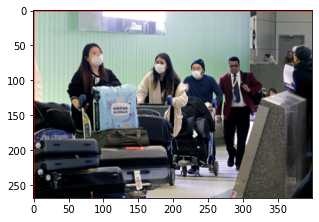

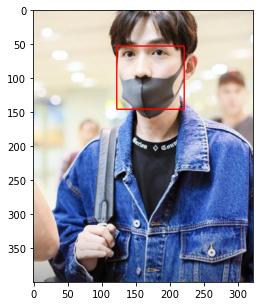

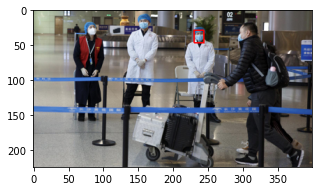

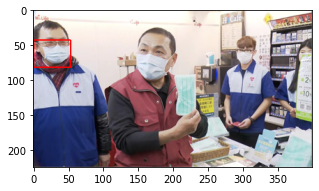

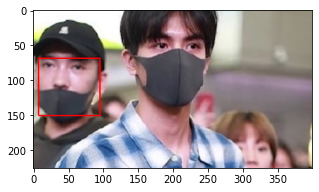

In [73]:
for i in test():
    plt.figure(figsize=(5, 5))
    plt.imshow(i)